Question - how should I treat the interpolation of currents and grid cell to a transect?

In [1]:
import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import transport

In [2]:
lon_min=-56
lat_min=53
lon_max=-52
lat_max=56

In [3]:
data_dir='/ocean/handres/glorys12/'
mask = xr.open_dataset(os.path.join(data_dir,'statics_subset_mask_bathy.nc'))
mask = mask.sel(latitude=slice(lat_min, lat_max),
                longitude=slice(lon_min, lon_max))
coords = xr.open_dataset(os.path.join(data_dir,'statics_subset_coordinates.nc'))
coords = coords.sel(latitude=slice(lat_min, lat_max),
                    longitude=slice(lon_min, lon_max))

In [4]:
transects = pd.read_csv('../../data/sections_info.txt', delim_whitespace=True,
                       names=['Shortname', 'Longname', 'lon1', 'lat1', 'lon2', 'lat2', 'Dir-E', 'Dir-N'],
                       header=0)

In [5]:
seal = transects[transects.Shortname=='SI']
seal

,Shortname,Longname,lon1,lat1,lon2,lat2,Dir-E,Dir-N
14,SI,Seal-Isle,-55.917366,53.146169,-52.007608,54.392137,1,-1


In [6]:
year='[1,2][0-9][0-9][0-9]'
month='[0,1][0-9]'
f = glob.glob(os.path.join(data_dir,f'*_{year}_daily{month}.nc'))
d = xr.open_mfdataset(f)
dsel = d.sel(time=slice('2002-11-01', '2003-06-01'),
             latitude=slice(lat_min, lat_max),
             longitude=slice(lon_min, lon_max))

In [7]:
num_points=100
lons = np.linspace(seal.lon1.values[0],
                   seal.lon2.values[0],
                   num=num_points)
lats = np.linspace(seal.lat1.values[0],
                   seal.lat2.values[0],
                   num=num_points)
dir_east_perp = seal['Dir-E'].values[0]
dir_north_perp = seal['Dir-N'].values[0]
transect_vector = transport.vectorize_transect(lons, lats,
                                               dir_east_perp,
                                               dir_north_perp)

In [8]:
u1 = transport.interpolate_transect(dsel.uo, lons, lats)

(1000.0, 0.0)

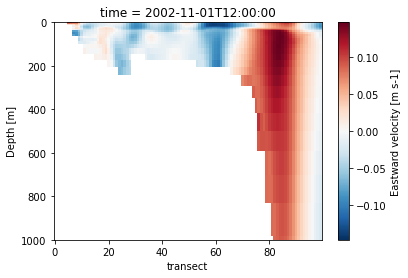

In [9]:
fig, ax = plt.subplots(1,1)
u1.isel(time=0).plot(ax=ax)
ax.set_ylim([1000,0])

In [10]:
lon_array = xr.DataArray(lons, dims='transect')
lat_array = xr.DataArray(lats, dims='transect')

No, fill nans with zeros first, and then interpolate

In [11]:
u2 = transport.interpolate_transect(dsel.uo, lons, lats, fill_value=0)

(1000.0, 0.0)

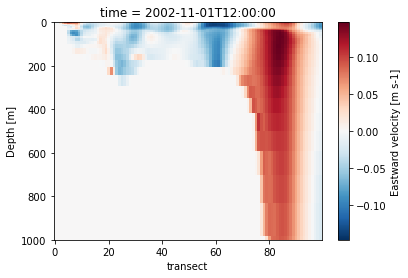

In [12]:
fig, ax = plt.subplots(1,1)
u2.isel(time=0).plot(ax=ax)
ax.set_ylim([1000,0])

In [13]:
mask_transect =transport.interpolate_transect(mask.mask, lons, lats, method='nearest')

In [14]:
depth = transport.interpolate_transect(mask.deptho, lons, lats)
depth2 = transport.interpolate_transect(mask.deptho, lons, lats, method='nearest')

(1000.0, 0.0)

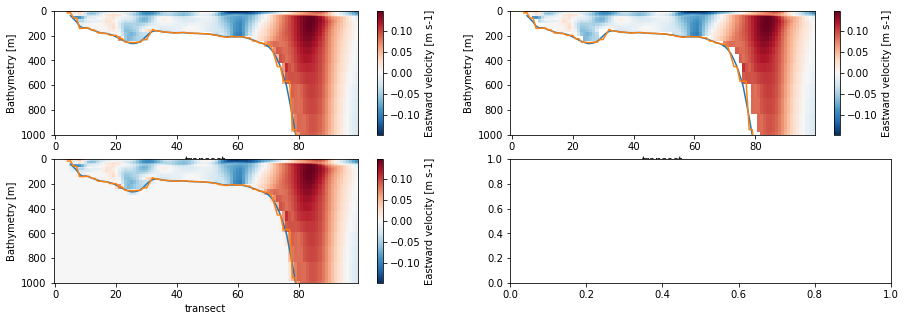

In [15]:
u2mask = u2.where(mask_transect)
fig, axs = plt.subplots(2,2, figsize=(15,5))
ax=axs[0,0]
u2mask.isel(time=0).plot(ax=ax)
depth.plot(ax=ax)
depth2.plot(ax=ax)
ax.set_ylim([1000,0])
ax=axs[0,1]
u1.isel(time=0).plot(ax=ax)
depth.plot(ax=ax)
depth2.plot(ax=ax)
ax.set_ylim([1000,0])
ax=axs[1,0]
u2.isel(time=0).plot(ax=ax)
depth.plot(ax=ax)
depth2.plot(ax=ax)
ax.set_ylim([1000,0])

In [16]:
e3t_transect =transport.interpolate_transect(coords.e3t, lons, lats)

(1000.0, 0.0)

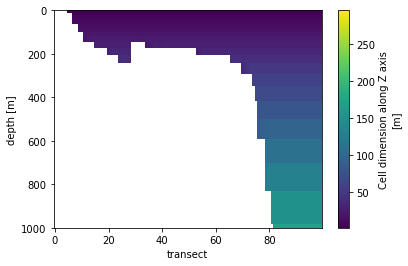

In [17]:
fig, ax = plt.subplots(1,1)
e3t_transect.plot(ax=ax)
ax.set_ylim([1000,0])

(1000.0, 0.0)

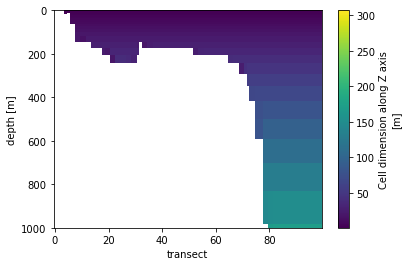

In [18]:
e3t_2 = transport.interpolate_transect(coords.e3t, lons, lats, method='nearest')
fig, ax = plt.subplots(1,1)
e3t_2.plot(ax=ax)
ax.set_ylim([1000,0])

(1000.0, 0.0)

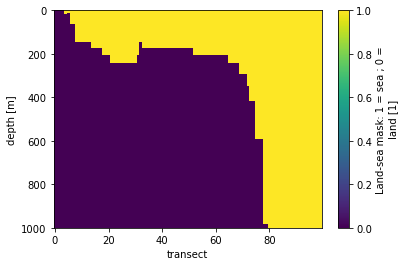

In [19]:
fig, ax = plt.subplots(1,1)
mask_transect.plot(ax=ax)
ax.set_ylim([1000,0])

In [20]:
H2 = (mask_transect*e3t_2).sum(dim='depth', skipna=True)

In [21]:
depth=depth.where(~np.isnan(depth), 0)
depth2=depth2.where(~np.isnan(depth2), 0)

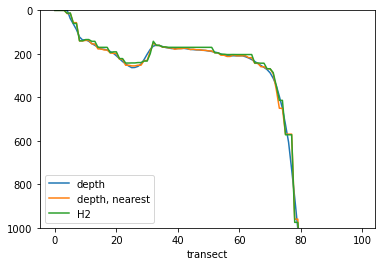

In [22]:
fig, ax = plt.subplots(1,1)
depth.plot(ax=ax, label= 'depth')
depth2.plot(ax=ax, label= 'depth, nearest')
H2.plot(ax=ax, label='H2')
ax.set_ylim([1000,0])
ax.legend()

In [23]:
V1=0
V2=0
V3=0
for i in range(len(transect_vector)):
    length=np.abs(transect_vector[i])
    V1 += depth.isel(transect=i)*length
    V2 += H2.isel(transect=i)*length
    V3 += depth2.isel(transect=i)*length

In [24]:
print(V1, V2, V3)

<xarray.DataArray 'deptho' ()>
array(2.58224738e+08)
Coordinates:
    longitude  float64 -55.92
    latitude   float64 53.15 <xarray.DataArray ()>
array(2.50596288e+08)
Coordinates:
    longitude  float64 -55.92
    latitude   float64 53.15 <xarray.DataArray 'deptho' ()>
array(2.57362337e+08)
Coordinates:
    longitude  float64 -55.92
    latitude   float64 53.15


# Decisions
* In velocity fields, fill NaNs with zeros before interpolating
* In depth related fields (like mask, grid spacing) use nearest as interpolation method to avoid creating/destroying volume.